# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    small_in_upsampled = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer1 = layers.concatenate([small_in_upsampled, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer2 = separable_conv2d_batchnorm(output_layer1, filters)
    output_layer3 = separable_conv2d_batchnorm(output_layer2, filters)
    return output_layer3

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [ ]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    enc1 = encoder_block(inputs, 16, 2)
    enc2 = encoder_block(enc1, 32, 2)
    enc3 = encoder_block(enc2, 64, 2)
    enc4 = encoder_block(enc3, 128, 2)
    #enc5 = encoder_block(enc4, 256, 2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    con1 = conv2d_batchnorm(enc4, 512, 1, 1)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dec1 = decoder_block(con1, enc3, 128)
    dec2 = decoder_block(dec1, enc2, 64)
    dec3 = decoder_block(dec2, enc1, 32)
    #dec4 = decoder_block(dec3, enc1, 32)
    x    = decoder_block(dec3, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

In [6]:
# the deeper model
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    enc1 = encoder_block(inputs, 16, 2)
    enc2 = encoder_block(enc1, 32, 2)
    enc3 = encoder_block(enc2, 64, 2)
    enc4 = encoder_block(enc3, 128, 2)
    enc5 = encoder_block(enc4, 256, 2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    con1 = conv2d_batchnorm(enc5, 512, 1, 1)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dec1 = decoder_block(con1, enc4, 256)
    dec2 = decoder_block(dec1, enc3, 128)
    dec3 = decoder_block(dec2, enc2, 64)
    dec4 = decoder_block(dec3, enc1, 32)
    x    = decoder_block(dec4, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

In [6]:
# the model 3
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    enc1 = encoder_block(inputs, 16, 2)
    enc2 = encoder_block(enc1, 64, 2)
    enc3 = encoder_block(enc2, 256, 2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    con1 = conv2d_batchnorm(enc3, 1024, 1, 1)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dec1 = decoder_block(con1, enc2, 256)
    dec2 = decoder_block(dec1, enc1, 64)
    x    = decoder_block(dec2, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [ ]:
import numpy as np

In [ ]:
# to generate random Hyper-Parameters (random grid method)
def generate_rand_hp(lr_a = -1, lr_b = -3, bs_a = 5, bs_b = 7, num_data=4131):
    
    # generate random number between [a, b)
    r = (lr_b - lr_a) * np.random.rand() + lr_a
    
    # logarithmic scale 
    learning_rate = 10 ** r
    
    # batch_size
    batch_size = 2 ** np.random.randint(bs_a, bs_b)
    # the loss curve was saturating after 10-25 epochs
    num_epochs = 25
    steps_per_epoch = (4131 // batch_size) # * 3
    validation_steps = 50
    workers = 4
    
    return learning_rate, batch_size, num_epochs, steps_per_epoch, validation_steps, workers

In [ ]:
#learning_rate = 0.01
#batch_size = 64
#num_epochs = 100
#steps_per_epoch = 100
#validation_steps = 50
#workers = 4

In [ ]:
# smaller model
best_hp = {'learning_rate': 0., 
           'batch_size': 0, 
           'num_epochs': 0,
           'steps_per_epoch': 100, 
           'validation_steps': 50, 
           'workers': 4}

best_final_score = 0.

num_itr = 10

for itr in range(num_itr):
    rand_hp = generate_rand_hp()
    learning_rate, batch_size, num_epochs, steps_per_epoch, validation_steps, workers = rand_hp
    
    print("the randomly generated Hyper-Parameters : ", rand_hp)
    
    """
    DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
    """
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)
    
    run_num = 'run_' + str(itr)

    val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                            run_num,'patrol_with_targ', 'sample_evaluation_data') 

    val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                            run_num,'patrol_non_targ', 'sample_evaluation_data') 

    val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                            run_num,'following_images', 'sample_evaluation_data')
    
    # images while following the target
    im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
    for i in range(3):
        im_tuple = plotting_tools.load_images(im_files[i])
        plotting_tools.show_images(im_tuple)
        
    # images while at patrol without target
    im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
    for i in range(3):
        im_tuple = plotting_tools.load_images(im_files[i])
        plotting_tools.show_images(im_tuple)
        
       
    # images while at patrol with target
    im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
    for i in range(3):
        im_tuple = plotting_tools.load_images(im_files[i])
        plotting_tools.show_images(im_tuple)

    # Scores for while the quad is following behind the target. 
    true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

    # Scores for images while the quad is on patrol and the target is not visable
    true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

    # This score measures how well the neural network can detect the target from far away
    true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

    # Sum all the true positives, etc from the three datasets to get a weight for the score
    true_pos = true_pos1 + true_pos2 + true_pos3
    false_pos = false_pos1 + false_pos2 + false_pos3
    false_neg = false_neg1 + false_neg2 + false_neg3

    weight = true_pos/(true_pos+false_neg+false_pos)
    print(weight)

    # The IoU for the dataset that never includes the hero is excluded from grading
    final_IoU = (iou1 + iou3)/2
    print(final_IoU)

    # And the final grade score is 
    final_score = final_IoU * weight
    print(final_score)
    
    if final_score > best_final_score:
        best_final_score = final_score

        best_hp['learning_rate']    = learning_rate
        best_hp['batch_size']       = batch_size 
        best_hp['num_epochs']       = num_epochs
        best_hp['steps_per_epoch']  = steps_per_epoch
        best_hp['validation_steps'] = validation_steps
        best_hp['workers']          = workers
        
        print("a new better parameter : {}".format(best_hp))
        
        # Save your trained model weights
        weight_file_name = 'model_weights'
        model_tools.save_network(model, weight_file_name)
    
    print('#' * 25 + ', ' + str(itr) + ' iteration finished.')

In [ ]:
#using the deeper model

best_hp = {'learning_rate': 0., 
           'batch_size': 0, 
           'num_epochs': 0,
           'steps_per_epoch': 100, 
           'validation_steps': 50, 
           'workers': 4}

best_final_score = 0.

num_itr = 2

for itr in range(num_itr):
    rand_hp = generate_rand_hp()
    learning_rate, batch_size, num_epochs, steps_per_epoch, validation_steps, workers = rand_hp
    
    print("the randomly generated Hyper-Parameters : ", rand_hp)
    
    """
    DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
    """
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)
    
    run_num = 'run_' + str(itr)

    val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                            run_num,'patrol_with_targ', 'sample_evaluation_data') 

    val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                            run_num,'patrol_non_targ', 'sample_evaluation_data') 

    val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                            run_num,'following_images', 'sample_evaluation_data')
    
    # images while following the target
    im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
    for i in range(3):
        im_tuple = plotting_tools.load_images(im_files[i])
        plotting_tools.show_images(im_tuple)
        
    # images while at patrol without target
    im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
    for i in range(3):
        im_tuple = plotting_tools.load_images(im_files[i])
        plotting_tools.show_images(im_tuple)
        
       
    # images while at patrol with target
    im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
    for i in range(3):
        im_tuple = plotting_tools.load_images(im_files[i])
        plotting_tools.show_images(im_tuple)

    # Scores for while the quad is following behind the target. 
    true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

    # Scores for images while the quad is on patrol and the target is not visable
    true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

    # This score measures how well the neural network can detect the target from far away
    true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

    # Sum all the true positives, etc from the three datasets to get a weight for the score
    true_pos = true_pos1 + true_pos2 + true_pos3
    false_pos = false_pos1 + false_pos2 + false_pos3
    false_neg = false_neg1 + false_neg2 + false_neg3

    weight = true_pos/(true_pos+false_neg+false_pos)
    print(weight)

    # The IoU for the dataset that never includes the hero is excluded from grading
    final_IoU = (iou1 + iou3)/2
    print(final_IoU)

    # And the final grade score is 
    final_score = final_IoU * weight
    print(final_score)
    
    if final_score > best_final_score:
        best_final_score = final_score

        best_hp['learning_rate']    = learning_rate
        best_hp['batch_size']       = batch_size 
        best_hp['num_epochs']       = num_epochs
        best_hp['steps_per_epoch']  = steps_per_epoch
        best_hp['validation_steps'] = validation_steps
        best_hp['workers']          = workers
        
        print("a new better parameter : {}".format(best_hp))
        
        # Save your trained model weights
        weight_file_name = 'model_weights'
        model_tools.save_network(model, weight_file_name)
    
    print('#' * 25 + ', ' + str(itr) + ' iteration finished.')

In [8]:
learning_rate = 0.015
batch_size = 32
num_epochs = 75
steps_per_epoch = 4131 // 32
validation_steps = 50
workers = 4

Epoch 1/75
128/129 [============================>.] - ETA: 0s - loss: 0.1583

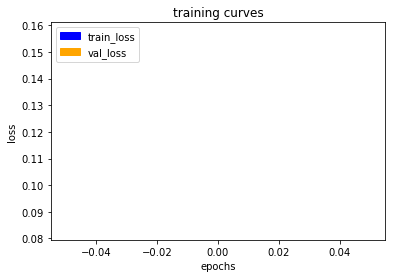

129/129 [==============================] - 61s - loss: 0.1574 - val_loss: 0.0832
Epoch 2/75
128/129 [============================>.] - ETA: 0s - loss: 0.0461

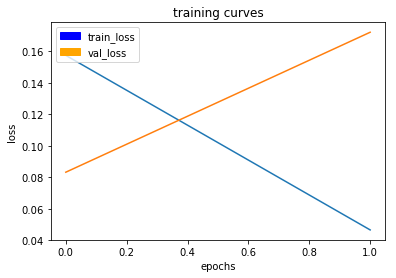

129/129 [==============================] - 57s - loss: 0.0464 - val_loss: 0.1721
Epoch 3/75
128/129 [============================>.] - ETA: 0s - loss: 0.0408

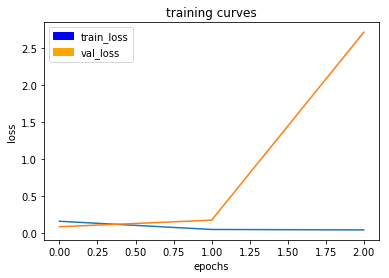

129/129 [==============================] - 57s - loss: 0.0407 - val_loss: 2.7096
Epoch 4/75
128/129 [============================>.] - ETA: 0s - loss: 0.0355

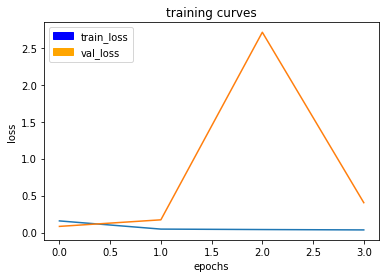

129/129 [==============================] - 57s - loss: 0.0354 - val_loss: 0.4040
Epoch 5/75
128/129 [============================>.] - ETA: 0s - loss: 0.0362

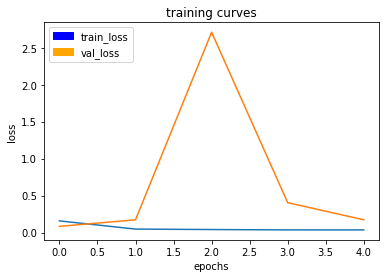

129/129 [==============================] - 57s - loss: 0.0362 - val_loss: 0.1725
Epoch 6/75
128/129 [============================>.] - ETA: 0s - loss: 0.0310

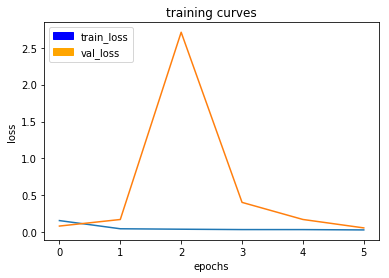

129/129 [==============================] - 57s - loss: 0.0309 - val_loss: 0.0582
Epoch 7/75
128/129 [============================>.] - ETA: 0s - loss: 0.0278

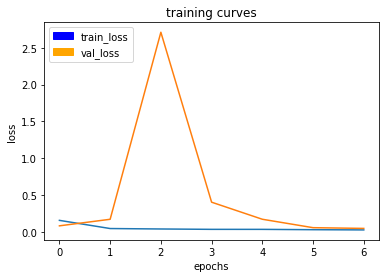

129/129 [==============================] - 57s - loss: 0.0278 - val_loss: 0.0483
Epoch 8/75
128/129 [============================>.] - ETA: 0s - loss: 0.0277

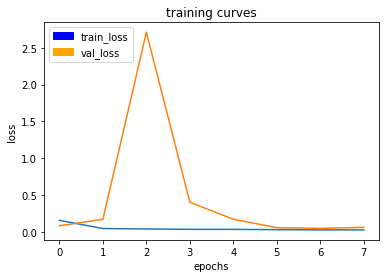

129/129 [==============================] - 57s - loss: 0.0277 - val_loss: 0.0623
Epoch 9/75
128/129 [============================>.] - ETA: 0s - loss: 0.0278

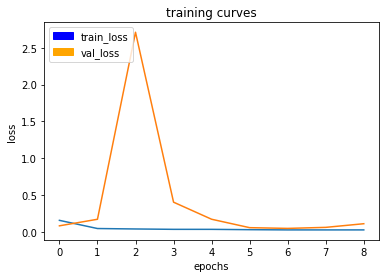

129/129 [==============================] - 57s - loss: 0.0279 - val_loss: 0.1118
Epoch 10/75
128/129 [============================>.] - ETA: 0s - loss: 0.0267

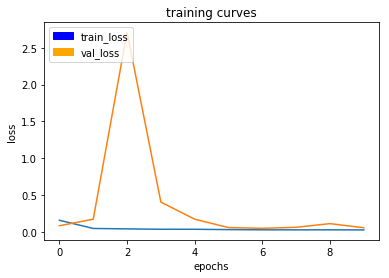

129/129 [==============================] - 57s - loss: 0.0267 - val_loss: 0.0561
Epoch 11/75
128/129 [============================>.] - ETA: 0s - loss: 0.0252

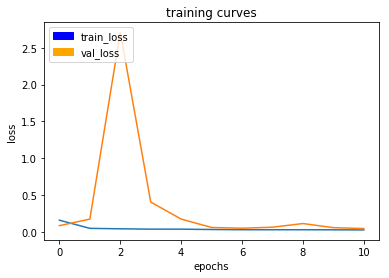

129/129 [==============================] - 57s - loss: 0.0252 - val_loss: 0.0435
Epoch 12/75
128/129 [============================>.] - ETA: 0s - loss: 0.0237

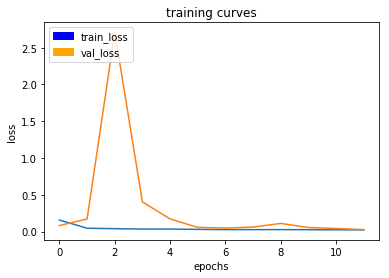

129/129 [==============================] - 57s - loss: 0.0237 - val_loss: 0.0278
Epoch 13/75
128/129 [============================>.] - ETA: 0s - loss: 0.0211

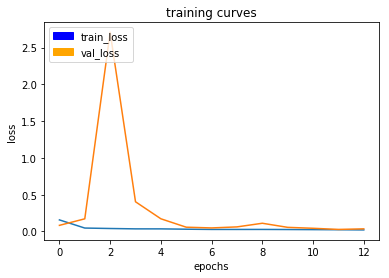

129/129 [==============================] - 57s - loss: 0.0211 - val_loss: 0.0358
Epoch 14/75
128/129 [============================>.] - ETA: 0s - loss: 0.0235

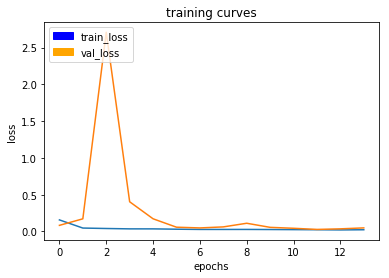

129/129 [==============================] - 57s - loss: 0.0235 - val_loss: 0.0487
Epoch 15/75
128/129 [============================>.] - ETA: 0s - loss: 0.0204

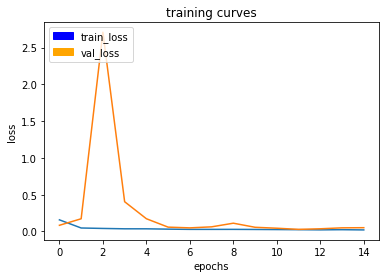

129/129 [==============================] - 57s - loss: 0.0204 - val_loss: 0.0506
Epoch 16/75
128/129 [============================>.] - ETA: 0s - loss: 0.0239

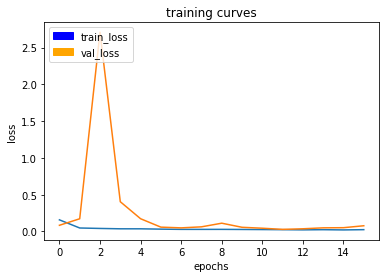

129/129 [==============================] - 57s - loss: 0.0239 - val_loss: 0.0770
Epoch 17/75
128/129 [============================>.] - ETA: 0s - loss: 0.0216

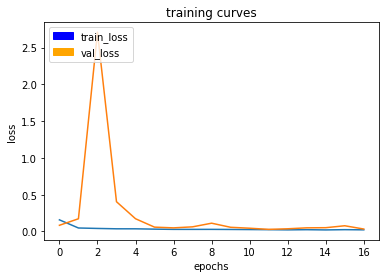

129/129 [==============================] - 57s - loss: 0.0216 - val_loss: 0.0324
Epoch 18/75
128/129 [============================>.] - ETA: 0s - loss: 0.0202

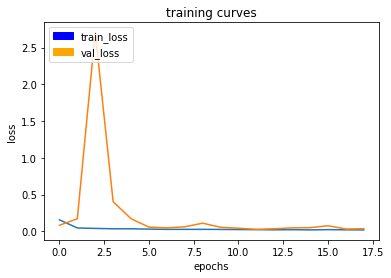

129/129 [==============================] - 57s - loss: 0.0203 - val_loss: 0.0363
Epoch 19/75
128/129 [============================>.] - ETA: 0s - loss: 0.0233

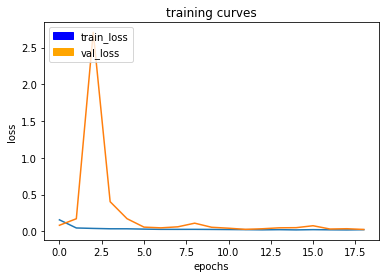

129/129 [==============================] - 57s - loss: 0.0233 - val_loss: 0.0263
Epoch 20/75
128/129 [============================>.] - ETA: 0s - loss: 0.0208

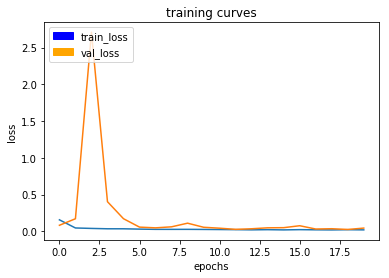

129/129 [==============================] - 57s - loss: 0.0208 - val_loss: 0.0449
Epoch 21/75
128/129 [============================>.] - ETA: 0s - loss: 0.0191

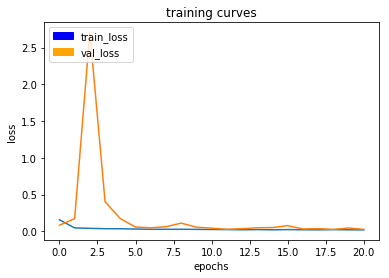

129/129 [==============================] - 57s - loss: 0.0191 - val_loss: 0.0269
Epoch 22/75
128/129 [============================>.] - ETA: 0s - loss: 0.0206

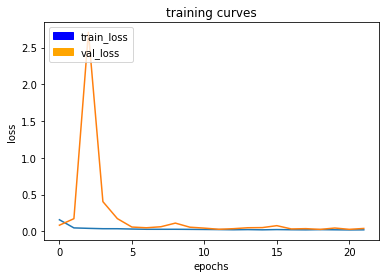

129/129 [==============================] - 57s - loss: 0.0206 - val_loss: 0.0391
Epoch 23/75
128/129 [============================>.] - ETA: 0s - loss: 0.0200

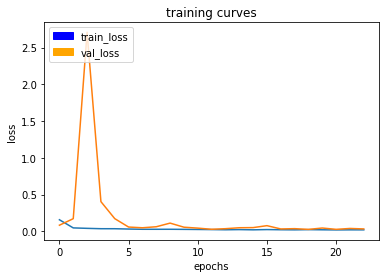

129/129 [==============================] - 57s - loss: 0.0200 - val_loss: 0.0326
Epoch 24/75
128/129 [============================>.] - ETA: 0s - loss: 0.0176

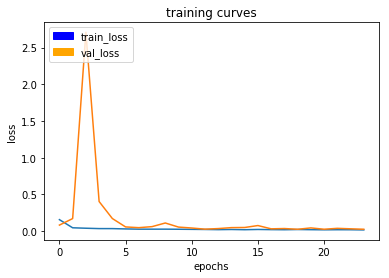

129/129 [==============================] - 57s - loss: 0.0176 - val_loss: 0.0267
Epoch 25/75
128/129 [============================>.] - ETA: 0s - loss: 0.0182

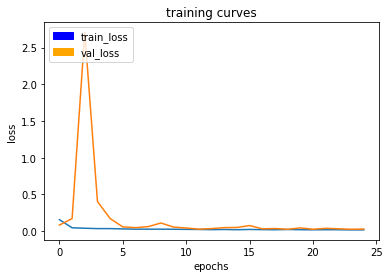

129/129 [==============================] - 57s - loss: 0.0182 - val_loss: 0.0291
Epoch 26/75
128/129 [============================>.] - ETA: 0s - loss: 0.0165

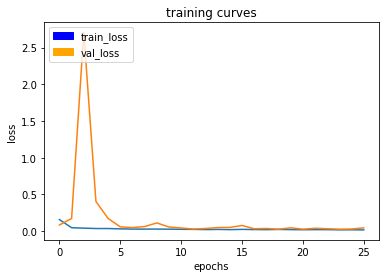

129/129 [==============================] - 57s - loss: 0.0165 - val_loss: 0.0442
Epoch 27/75
128/129 [============================>.] - ETA: 0s - loss: 0.0177

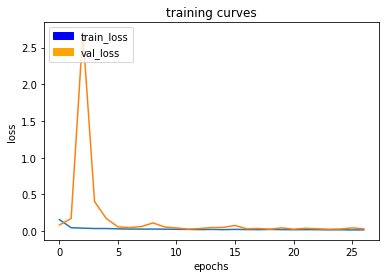

129/129 [==============================] - 57s - loss: 0.0177 - val_loss: 0.0321
Epoch 28/75
128/129 [============================>.] - ETA: 0s - loss: 0.0180

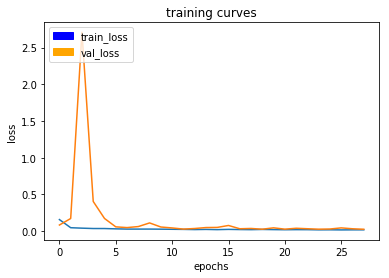

129/129 [==============================] - 57s - loss: 0.0179 - val_loss: 0.0256
Epoch 29/75
128/129 [============================>.] - ETA: 0s - loss: 0.0193

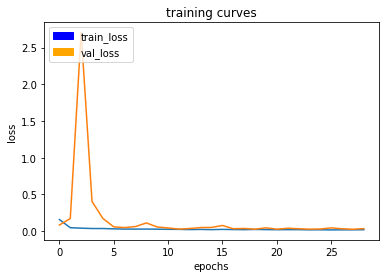

129/129 [==============================] - 57s - loss: 0.0192 - val_loss: 0.0341
Epoch 30/75
128/129 [============================>.] - ETA: 0s - loss: 0.0173

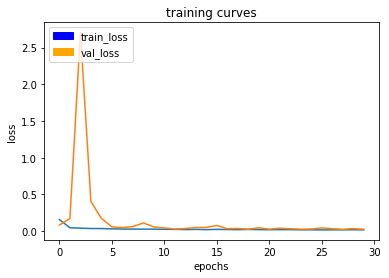

129/129 [==============================] - 57s - loss: 0.0172 - val_loss: 0.0260
Epoch 31/75
128/129 [============================>.] - ETA: 0s - loss: 0.0166

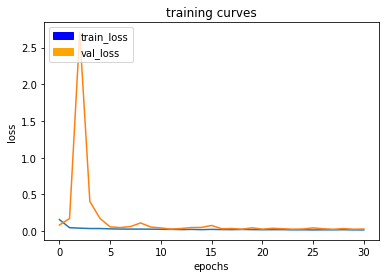

129/129 [==============================] - 57s - loss: 0.0165 - val_loss: 0.0291
Epoch 32/75
128/129 [============================>.] - ETA: 0s - loss: 0.0142

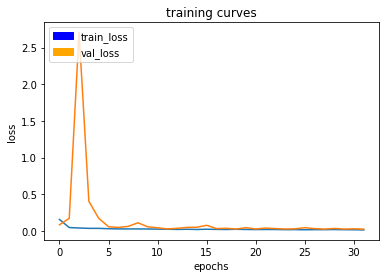

129/129 [==============================] - 57s - loss: 0.0142 - val_loss: 0.0250
Epoch 33/75
128/129 [============================>.] - ETA: 0s - loss: 0.0146

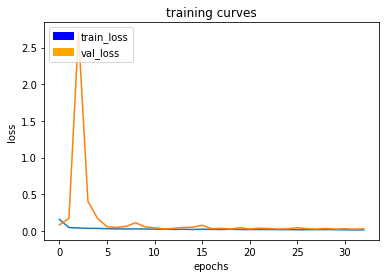

129/129 [==============================] - 57s - loss: 0.0146 - val_loss: 0.0287
Epoch 34/75
128/129 [============================>.] - ETA: 0s - loss: 0.0137

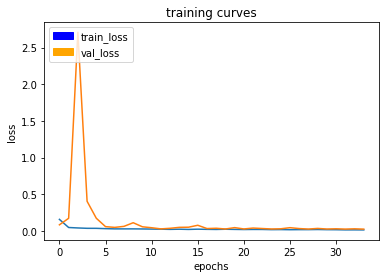

129/129 [==============================] - 57s - loss: 0.0137 - val_loss: 0.0243
Epoch 35/75
128/129 [============================>.] - ETA: 0s - loss: 0.0134

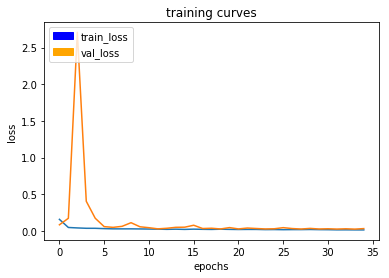

129/129 [==============================] - 57s - loss: 0.0134 - val_loss: 0.0313
Epoch 36/75
128/129 [============================>.] - ETA: 0s - loss: 0.0132

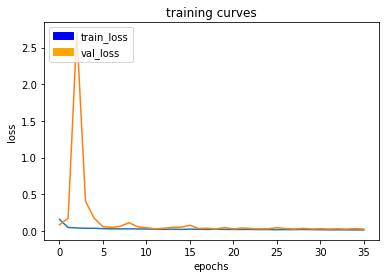

129/129 [==============================] - 57s - loss: 0.0132 - val_loss: 0.0241
Epoch 37/75
128/129 [============================>.] - ETA: 0s - loss: 0.0129

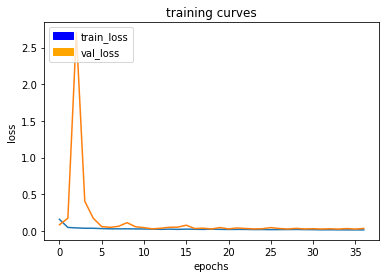

129/129 [==============================] - 57s - loss: 0.0129 - val_loss: 0.0336
Epoch 38/75
128/129 [============================>.] - ETA: 0s - loss: 0.0125

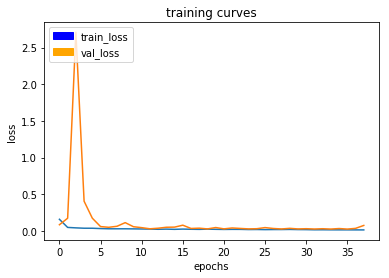

129/129 [==============================] - 57s - loss: 0.0125 - val_loss: 0.0736
Epoch 39/75
128/129 [============================>.] - ETA: 0s - loss: 0.0158

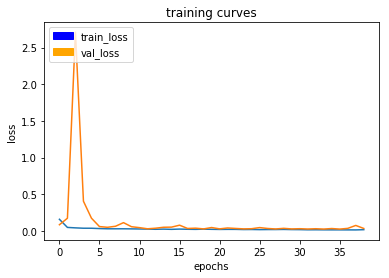

129/129 [==============================] - 57s - loss: 0.0158 - val_loss: 0.0323
Epoch 40/75
128/129 [============================>.] - ETA: 0s - loss: 0.0183

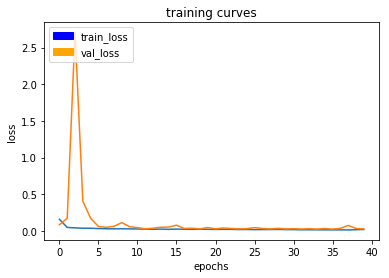

129/129 [==============================] - 57s - loss: 0.0183 - val_loss: 0.0267
Epoch 41/75
128/129 [============================>.] - ETA: 0s - loss: 0.0138

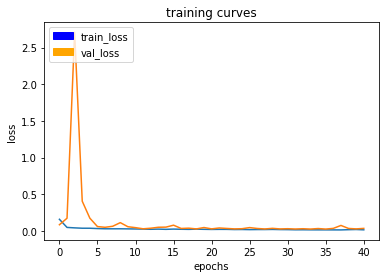

129/129 [==============================] - 57s - loss: 0.0138 - val_loss: 0.0333
Epoch 42/75
128/129 [============================>.] - ETA: 0s - loss: 0.0127

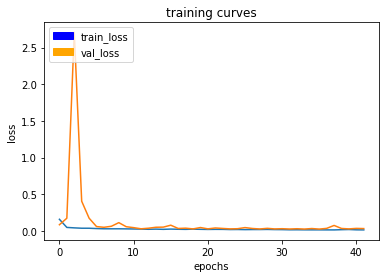

129/129 [==============================] - 57s - loss: 0.0127 - val_loss: 0.0308
Epoch 43/75
128/129 [============================>.] - ETA: 0s - loss: 0.0125

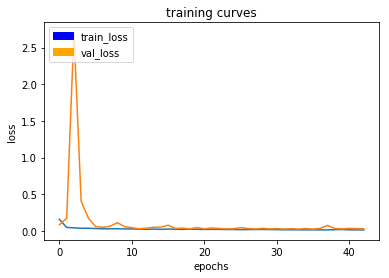

129/129 [==============================] - 57s - loss: 0.0125 - val_loss: 0.0279
Epoch 44/75
128/129 [============================>.] - ETA: 0s - loss: 0.0132

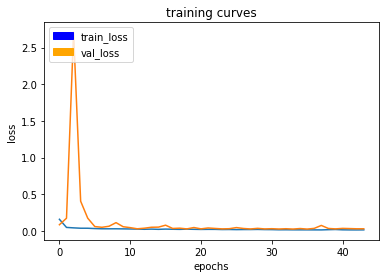

129/129 [==============================] - 57s - loss: 0.0132 - val_loss: 0.0280
Epoch 45/75
128/129 [============================>.] - ETA: 0s - loss: 0.0193

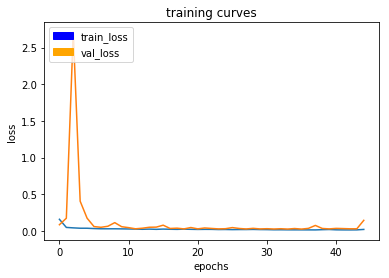

129/129 [==============================] - 57s - loss: 0.0193 - val_loss: 0.1433
Epoch 46/75
128/129 [============================>.] - ETA: 0s - loss: 0.0187

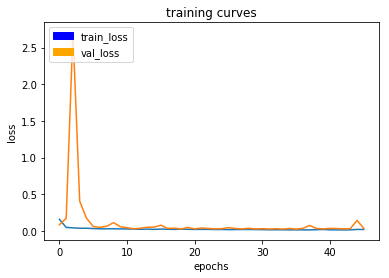

129/129 [==============================] - 57s - loss: 0.0187 - val_loss: 0.0336
Epoch 47/75
128/129 [============================>.] - ETA: 0s - loss: 0.0154

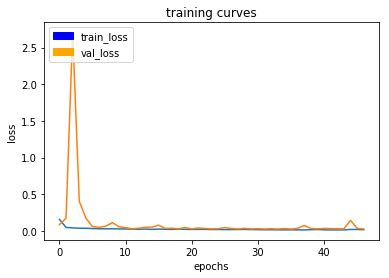

129/129 [==============================] - 57s - loss: 0.0154 - val_loss: 0.0261
Epoch 48/75
128/129 [============================>.] - ETA: 0s - loss: 0.0158

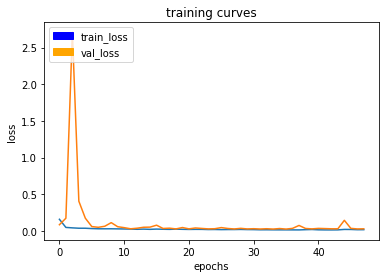

129/129 [==============================] - 57s - loss: 0.0157 - val_loss: 0.0276
Epoch 49/75
128/129 [============================>.] - ETA: 0s - loss: 0.0131

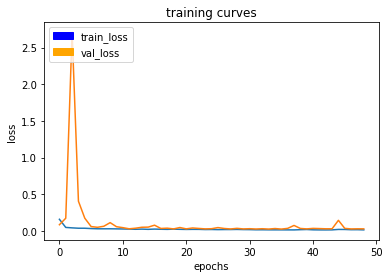

129/129 [==============================] - 57s - loss: 0.0131 - val_loss: 0.0270
Epoch 50/75
128/129 [============================>.] - ETA: 0s - loss: 0.0126

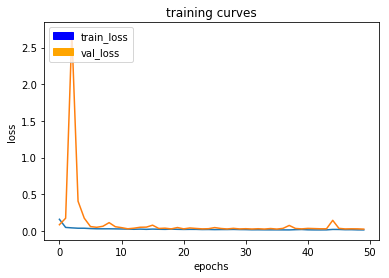

129/129 [==============================] - 57s - loss: 0.0126 - val_loss: 0.0235
Epoch 51/75
128/129 [============================>.] - ETA: 0s - loss: 0.0120

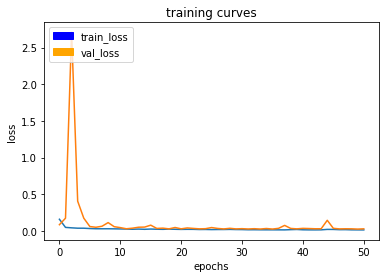

129/129 [==============================] - 57s - loss: 0.0120 - val_loss: 0.0269
Epoch 52/75
128/129 [============================>.] - ETA: 0s - loss: 0.0118

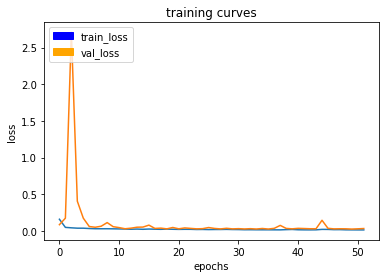

129/129 [==============================] - 57s - loss: 0.0119 - val_loss: 0.0308
Epoch 53/75
128/129 [============================>.] - ETA: 0s - loss: 0.0146

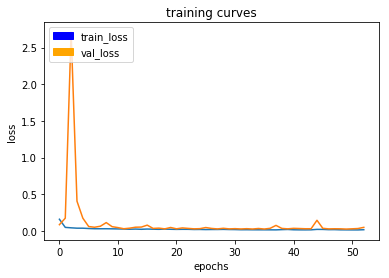

129/129 [==============================] - 57s - loss: 0.0146 - val_loss: 0.0467
Epoch 54/75
128/129 [============================>.] - ETA: 0s - loss: 0.0179

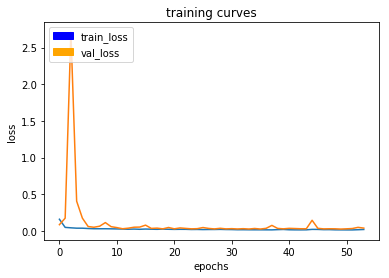

129/129 [==============================] - 57s - loss: 0.0178 - val_loss: 0.0366
Epoch 55/75
128/129 [============================>.] - ETA: 0s - loss: 0.0147

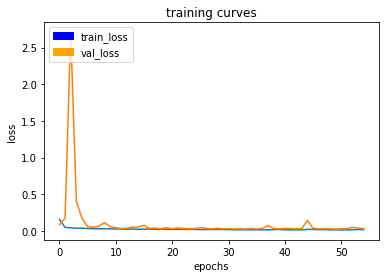

129/129 [==============================] - 57s - loss: 0.0148 - val_loss: 0.0269
Epoch 56/75
128/129 [============================>.] - ETA: 0s - loss: 0.0177

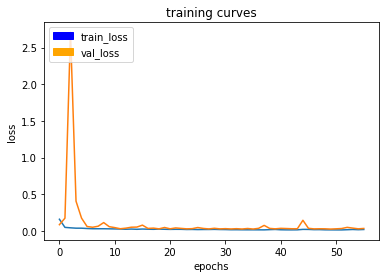

129/129 [==============================] - 57s - loss: 0.0176 - val_loss: 0.0318
Epoch 57/75
128/129 [============================>.] - ETA: 0s - loss: 0.0141

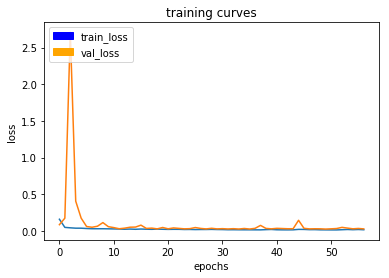

129/129 [==============================] - 57s - loss: 0.0141 - val_loss: 0.0259
Epoch 58/75
128/129 [============================>.] - ETA: 0s - loss: 0.0122

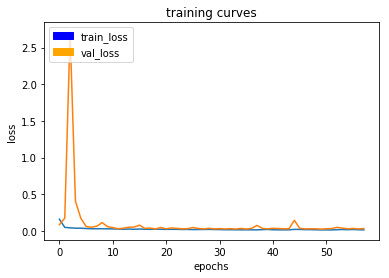

129/129 [==============================] - 57s - loss: 0.0122 - val_loss: 0.0309
Epoch 59/75
128/129 [============================>.] - ETA: 0s - loss: 0.0204

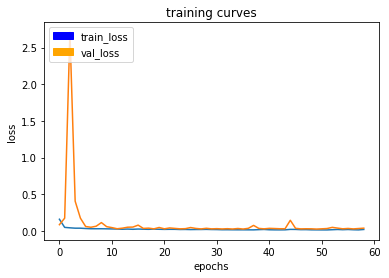

129/129 [==============================] - 57s - loss: 0.0204 - val_loss: 0.0357
Epoch 60/75
128/129 [============================>.] - ETA: 0s - loss: 0.0165

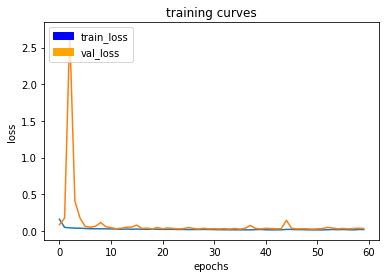

129/129 [==============================] - 57s - loss: 0.0165 - val_loss: 0.0306
Epoch 61/75
128/129 [============================>.] - ETA: 0s - loss: 0.0126

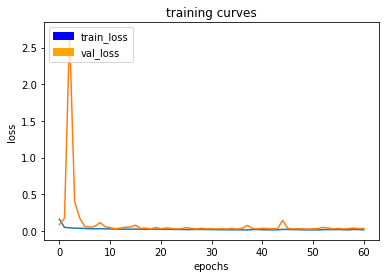

129/129 [==============================] - 57s - loss: 0.0126 - val_loss: 0.0317
Epoch 62/75
128/129 [============================>.] - ETA: 0s - loss: 0.0120

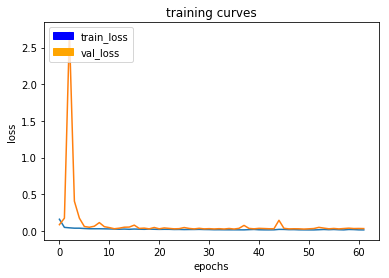

129/129 [==============================] - 57s - loss: 0.0120 - val_loss: 0.0300
Epoch 63/75
128/129 [============================>.] - ETA: 0s - loss: 0.0121

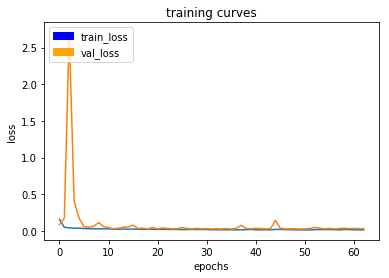

129/129 [==============================] - 57s - loss: 0.0121 - val_loss: 0.0286
Epoch 64/75
128/129 [============================>.] - ETA: 0s - loss: 0.0129

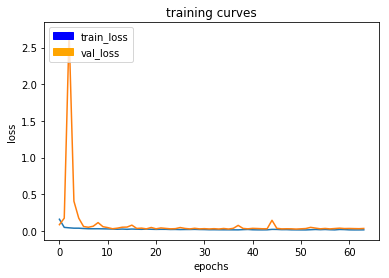

129/129 [==============================] - 57s - loss: 0.0129 - val_loss: 0.0316
Epoch 65/75
128/129 [============================>.] - ETA: 0s - loss: 0.0125

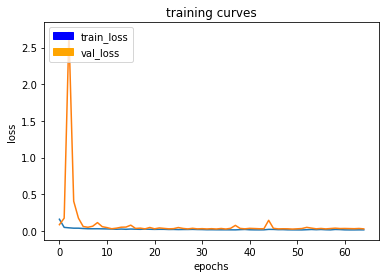

129/129 [==============================] - 57s - loss: 0.0125 - val_loss: 0.0262
Epoch 66/75
128/129 [============================>.] - ETA: 0s - loss: 0.0125

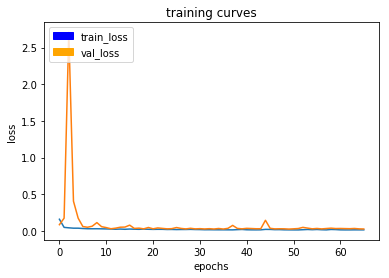

129/129 [==============================] - 57s - loss: 0.0125 - val_loss: 0.0246
Epoch 67/75
128/129 [============================>.] - ETA: 0s - loss: 0.0115

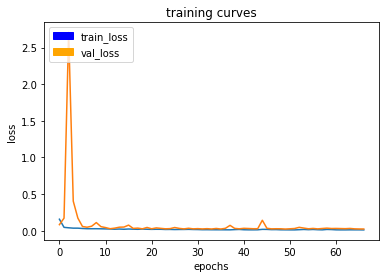

129/129 [==============================] - 57s - loss: 0.0115 - val_loss: 0.0240
Epoch 68/75
128/129 [============================>.] - ETA: 0s - loss: 0.0131

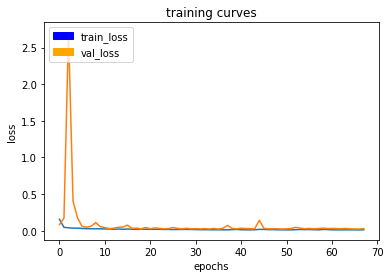

129/129 [==============================] - 57s - loss: 0.0131 - val_loss: 0.0287
Epoch 69/75
128/129 [============================>.] - ETA: 0s - loss: 0.0118

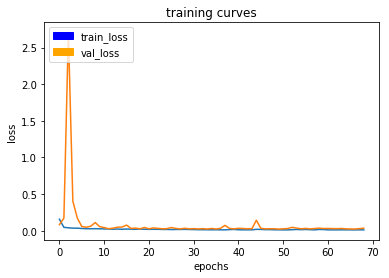

129/129 [==============================] - 57s - loss: 0.0117 - val_loss: 0.0349
Epoch 70/75
128/129 [============================>.] - ETA: 0s - loss: 0.0111

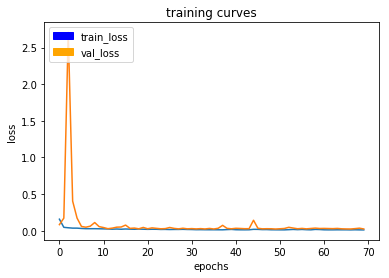

129/129 [==============================] - 57s - loss: 0.0111 - val_loss: 0.0241
Epoch 71/75
128/129 [============================>.] - ETA: 0s - loss: 0.0108

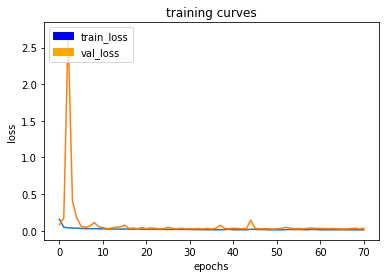

129/129 [==============================] - 57s - loss: 0.0108 - val_loss: 0.0343
Epoch 72/75
128/129 [============================>.] - ETA: 0s - loss: 0.0107

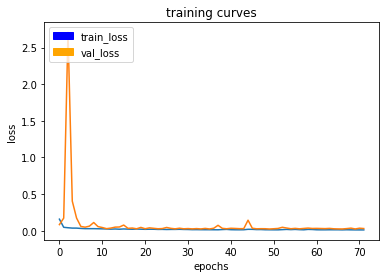

129/129 [==============================] - 57s - loss: 0.0107 - val_loss: 0.0295
Epoch 73/75
128/129 [============================>.] - ETA: 0s - loss: 0.0106

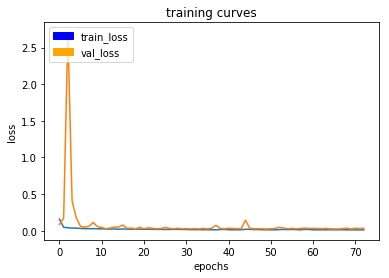

129/129 [==============================] - 57s - loss: 0.0106 - val_loss: 0.0321
Epoch 74/75
128/129 [============================>.] - ETA: 0s - loss: 0.0113

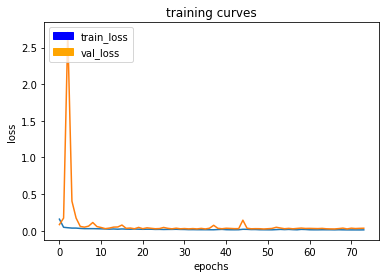

129/129 [==============================] - 57s - loss: 0.0113 - val_loss: 0.0335
Epoch 75/75
128/129 [============================>.] - ETA: 0s - loss: 0.0115

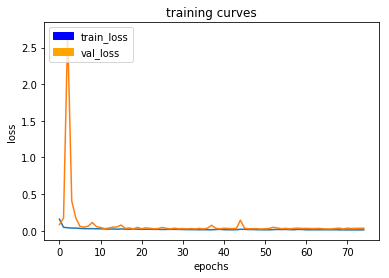

129/129 [==============================] - 57s - loss: 0.0115 - val_loss: 0.0341


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [20]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [21]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [22]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

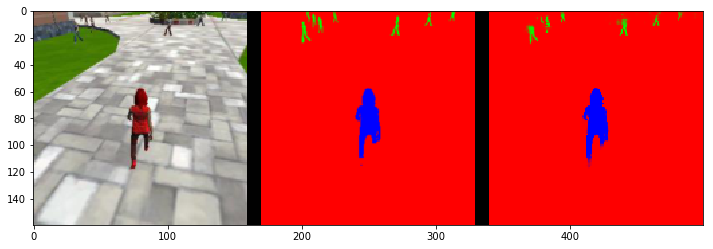

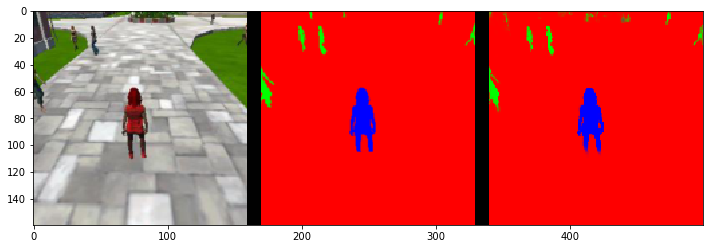

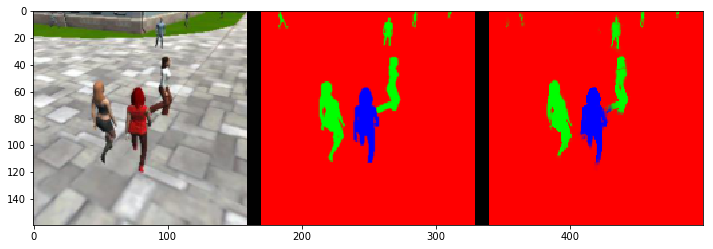

In [23]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

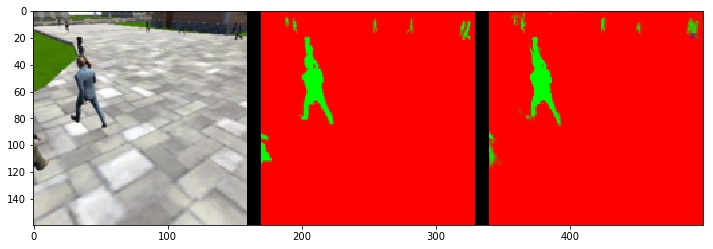

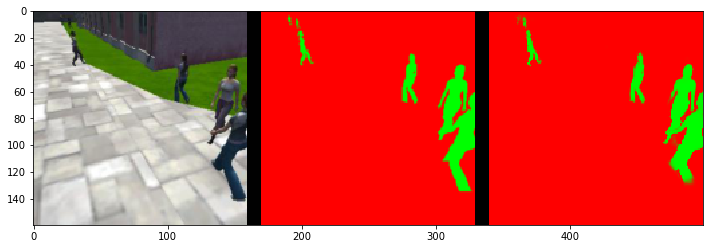

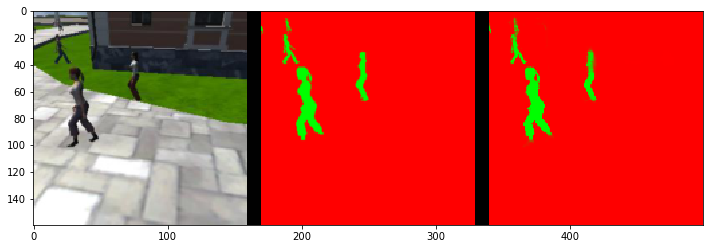

In [24]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

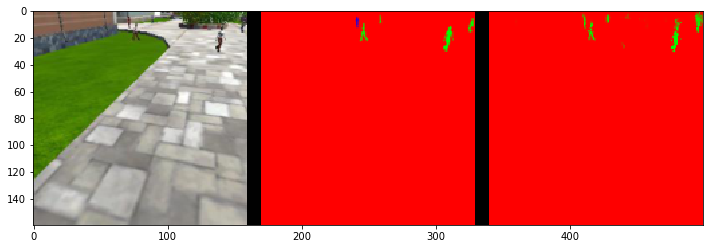

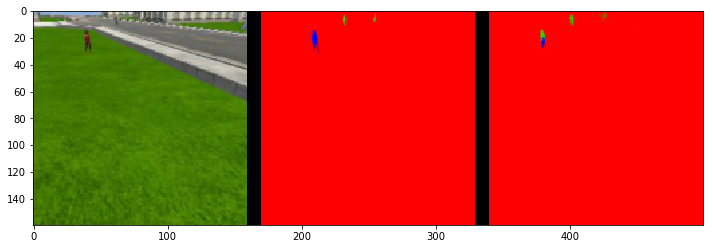

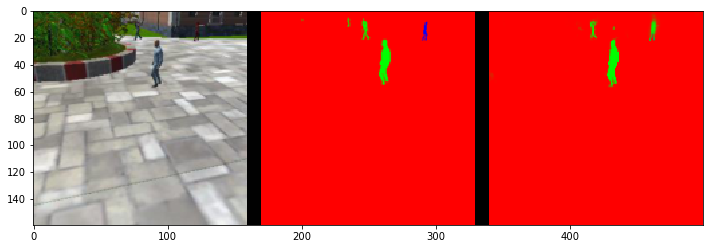

In [25]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [26]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9960960464023674
average intersection over union for other people is 0.3939160706281827
average intersection over union for the hero is 0.9278455456674423
number true positives: 539, number false positives: 0, number false negatives: 0


In [27]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9902542985631233
average intersection over union for other people is 0.8025150949573301
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 39, number false negatives: 0


In [28]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9971313952677134
average intersection over union for other people is 0.4692958923881602
average intersection over union for the hero is 0.22198816018696424
number true positives: 135, number false positives: 0, number false negatives: 166


In [29]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7667804323094426


In [30]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.574916852927


In [31]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.44083499303
